# World Data League 2023

## 🎯 Challenge

Avencas Marine Protected Area: Predict the future of the local ecosystem and its species



## Team: JKL & Frank
## 👥 Authors
* Joydeep Chatterjee
* Kate Crawford
* Lara Strachan
* Frank Novak

## 💻 Development

In [2]:
#Libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px

#Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling & Metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

**Load the Dataset**

[Access the data here](https://docs.google.com/spreadsheets/d/18kvrMgeKAffGDISQflb3iKTO2D4CXOVa/edit#gid=1573256966)

In [5]:
df = pd.read_csv('../all_species.csv')

**Data Preprocessing**

In [6]:
df['Datetime'] = df['Datetime'].astype('datetime64[ns]')
df["Weather Condition"].replace(to_replace="Sunny and Windy", value="Sunny", inplace=True)

In [7]:
numeric_features = ['Tide', 'Water temperature (ºC)', 'Sessile Coverage']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())]
)

datetime_features = ['Month', 'Year']
categorical_features = ['Weather Condition', 'Zone']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features + datetime_features),
    ]
)

**Temporal Split for training and validation data**

In [8]:
# Adapted from https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split

min_date = df.Datetime.iloc[0] #2011-11-28
max_date = df.Datetime.iloc[-1] #2020-11-16

# Cutoff Date: 2016-05-23
train_percent = .5
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between

# Define X and y
train_df = df.loc[df['Datetime'] <= train_cutoff]
test_df = df.loc[df['Datetime'] > train_cutoff]

# Set index for referencing
train_df.set_index('Datetime', inplace=True)
test_df.set_index('Datetime', inplace=True)

# Set X and y
X_train = train_df[numeric_features + categorical_features + datetime_features] #(1318, 7)
y_train = train_df['Abundance (ind/m2)'] #(1318,)
X_test = test_df[numeric_features + categorical_features + datetime_features] #(561, 7)
y_test = test_df['Abundance (ind/m2)'] #(561,)

**Random Forest Regressor** 

In [12]:
# Create the pipeline with preprocessor and random forest regressor
forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestRegressor(random_state = 0))
])

# Fit the pipeline on the data
forest_pipeline.fit(X_train, y_train)

# Predict and score
forest_y_preds = forest_pipeline.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_y_preds)
forest_rmse = forest_mse**0.5
print("MSE: ", forest_mse)
print("RMSE: ", forest_rmse)

MSE:  0.13415957944022638
RMSE:  0.36627800840376207


In [13]:
toy_data = {'Datetime':'2020-12-18', 'Tide':0.8, 'Water temperature (ºC)': 16, 'Sessile Coverage': 60.0, 'Weather Condition':'Clear sky', 'Zone':'A', 'Month':12, 'Year':2020}
toy_df = pd.Series(toy_data)
toy_df

Datetime                  2020-12-18
Tide                             0.8
Water temperature (ºC)            16
Sessile Coverage                60.0
Weather Condition          Clear sky
Zone                               A
Month                             12
Year                            2020
dtype: object

In [19]:
# Predicting abundance for rising tides and temperatures
# Sessile coverage 8% above average
predicted_abundance = forest_pipeline.predict(pd.DataFrame(toy_df).T)
print("Predicted Abundace(ind/m2) for 2020-12-18: ", predicted_abundance)
print("Distance from last actual observation value for 2020-11-16: ", predicted_abundance - 0.0736)
print("Distance from last fitted value for 2020-11-16: ", predicted_abundance - 0.3269)

Predicted Abundace(ind/m2) for 2020-12-18:  [0.181]
Distance from last actual observation value for 2020-11-16:  [0.1074]
Distance from last fitted value for 2020-11-16:  [-0.1459]


## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

**Feature Importances**

In [13]:
# Compute importances and standard deviations
feature_names = forest_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = forest_pipeline.named_steps['forest'].feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_pipeline.named_steps['forest'].estimators_], axis=0)

# Load importances into a frame 
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

# Plot top 4 importances
fig = px.bar(forest_importances[:5], title="Feature importances using MDI")
fig.show()

**Compare actual values to predicted values**

In [14]:
# Create frame for results
actual_values = pd.DataFrame(y_test).reset_index()
actual_values = actual_values.groupby(actual_values['Datetime'].dt.year).mean()

fitted_values = pd.DataFrame(forest_y_preds, columns=['Abundance (ind/m2)'], index=y_test.index).reset_index()
fitted_values['Datetime'] = fitted_values['Datetime'].astype('datetime64[ns]')
fitted_values = fitted_values.groupby(fitted_values['Datetime'].dt.year).mean()


# Create identifiers for merging
fitted_values['Type'] = "Fitted Value"
actual_values['Type'] = "Actual Value"

# Merge frames
results = pd.concat([fitted_values, actual_values])
results.reset_index(inplace=True)

# Plot results
px.line(results, x='Datetime', y='Abundance (ind/m2)', color='Type')

<ipython-input-14-28de620b15b0>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-14-28de620b15b0>:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


Mapping species abundance in ArcGIS

[View the interactive map](https://lstrachan.maps.arcgis.com/apps/instant/slider/index.html?appid=5b02eae0a86f438783c6b082ab4a5209&locale=en-us)

**Understanding covariates**

- Tide does not have a cyclical or seasonal pattern in the graph
    - The measure in meters of the low tide. For more information see: https://oceanservice.noaa.gov/education/tutorial_tides/tides01_intro.html
- Sea temperature has a seaonsonal patter, is it stationary? Augmented Dickey-Fuller test (ADF Test)
- Sessile Coverage needs more exploration in its patterm
    - total % covered of the sample with sessile species
- Total / Abundence droppped off at the end of 2016, what happened?
    - How many individuals of mobile species studied were found in the sample per m2

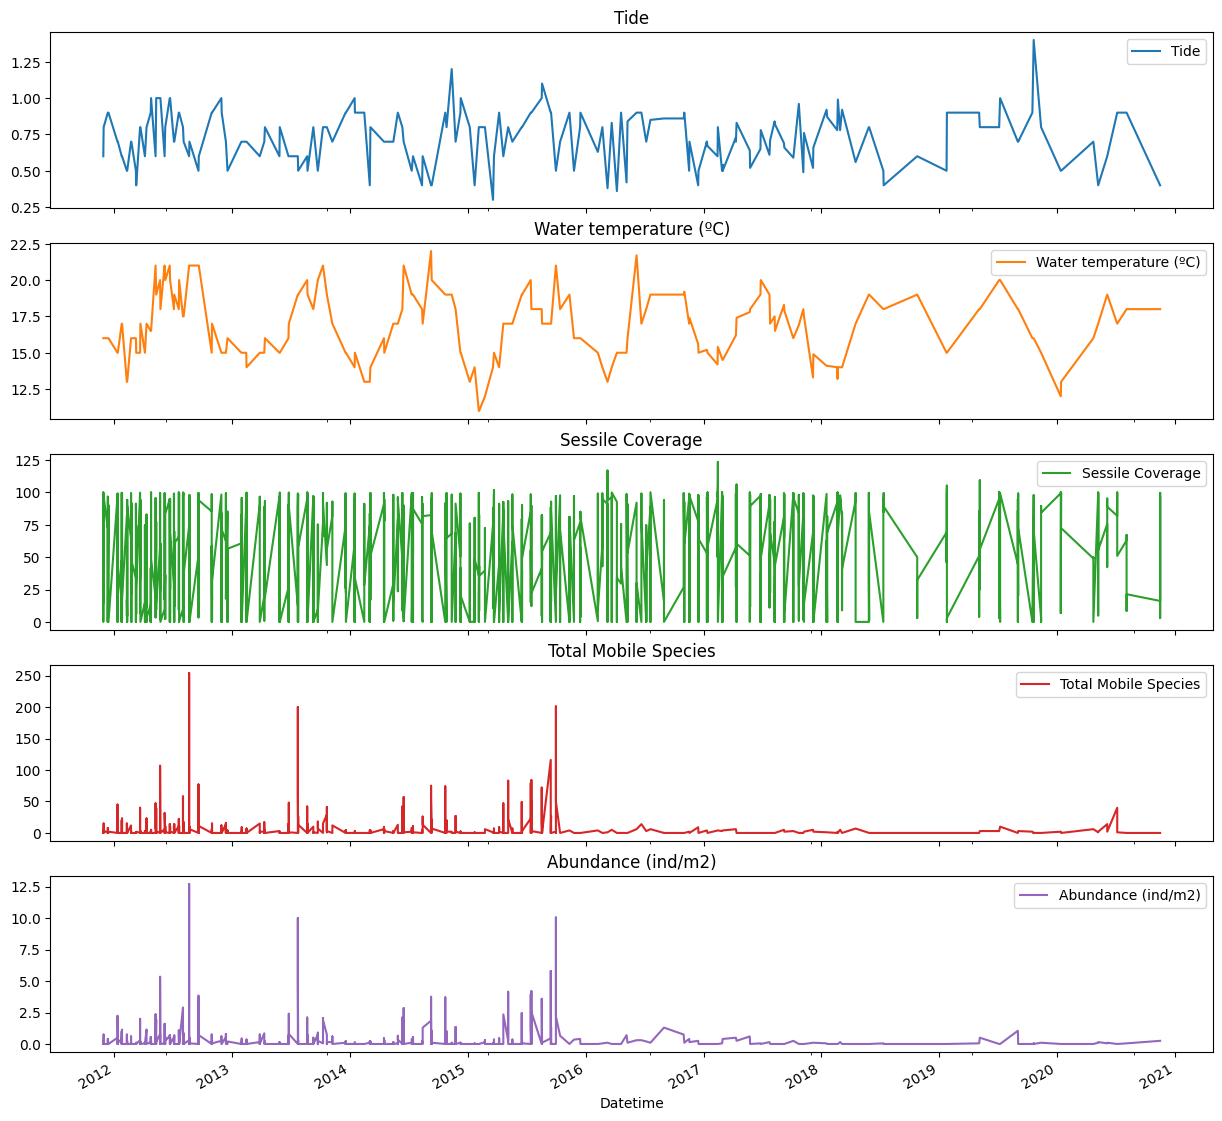

In [16]:
variables = ['Tide', 'Water temperature (ºC)', 'Sessile Coverage', 'Total Mobile Species','Abundance (ind/m2)']
df_dt = df.set_index('Datetime')
df_dt[variables].plot(subplots=True,figsize = (15,15),title=variables);

**Invasive Species Overtime**
- Asparagopsis armata has an increase in coverage after the drop in abundence in 2016, is this related?
- Cladophora sp. most aggressive invasive species 
    - 'Where Cladophora becomes a pest is generally where special circumstances cause such drastic overgrowth that algal blooms develop and form floating mats. Typical examples include where hypertrophication or high mortality of rival organisms produce high concentrations of dissolved phosphorus. Extensive floating mats prevent circulation that is necessary for the aeration of deeper water and, by blocking the light, they kill photosynthesising organisms growing beneath. The mats interfere with the fishing industry by clogging nets and preventing the use of lines. Where they wash ashore the masses of rotting material reduce shoreline property values along water bodies such as the Great Lakes in the United States.[4]'

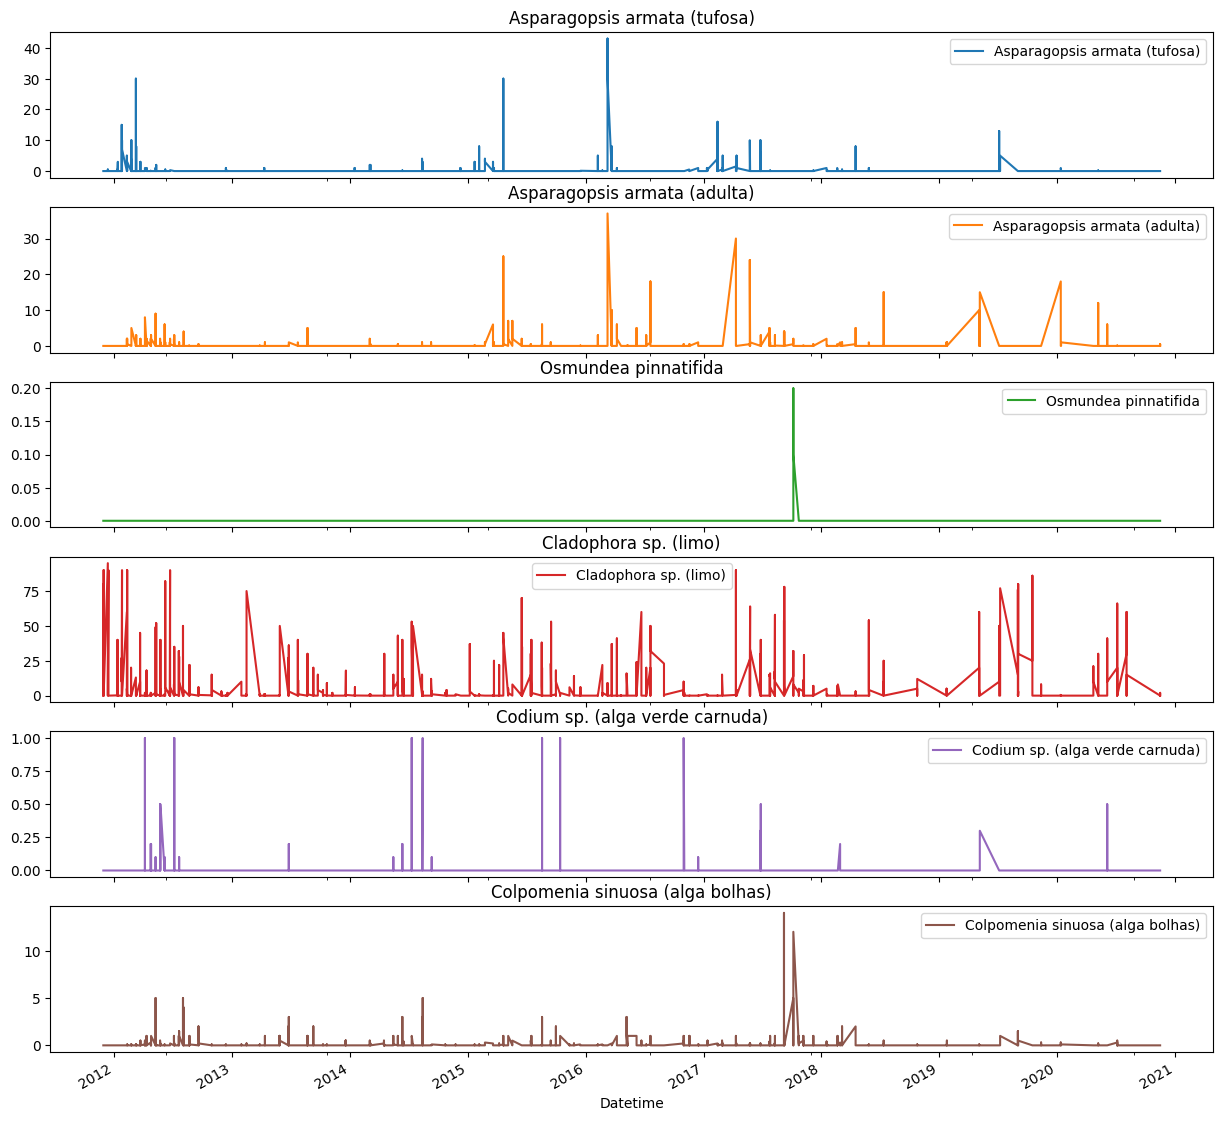

In [17]:
invasive = ['Asparagopsis armata (tufosa)',
            'Asparagopsis armata (adulta)', 
            'Osmundea pinnatifida',
            'Cladophora sp. (limo)',
            'Codium sp. (alga verde carnuda)',
            'Colpomenia sinuosa (alga bolhas)']

df_dt[invasive].plot(subplots=True,figsize=(15,15),title=invasive);

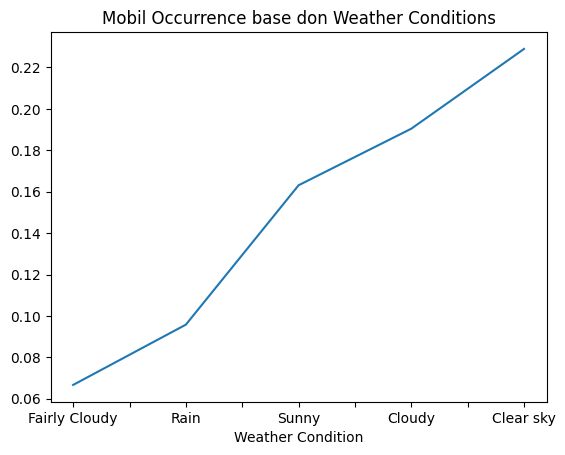

In [20]:
df_dt.groupby(by='Weather Condition')['Abundance (ind/m2)'].agg(np.mean).sort_values().plot(title='Mobil Occurrence base don Weather Conditions');